## 使得输出格式统一

我想把过去14天的藻密度和叶绿素a浓度，不仅仅作为target，也作为feature。那么代码应该如何修改？

In [11]:
# -*- coding: utf-8 -*-

# Python 3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from scipy import stats

# 读取数据
df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
df['date'] = pd.to_datetime(df['date'])

# 添加风力大于4级的特征
df['strong_wind'] = df['wind_power'].apply(lambda x: 1 if str(x).replace('级','').isdigit() and int(str(x).replace('级','')) >= 4 else 0)

# 添加天气one-hot编码
def split_weather(weather):
    if pd.isna(weather):
        return []
    return str(weather).split('-')

all_weather_types = set()
for weather in df['weather'].dropna():
    all_weather_types.update(split_weather(weather))

for weather_type in all_weather_types:
    df[f'weather_{weather_type}'] = df['weather'].apply(lambda x: 1 if pd.notna(x) and weather_type in split_weather(x) else 0)

# 选择需要分析相关性的列
target_cols = ['density_mean_y', 'density_lower_y', 'density_upper_y', 
               'chla_mean', 'chla_lower', 'chla_upper']

# 选择所有特征列,增加特征选择
exclude_cols = target_cols + ['date', 'density_mean_x', 'density_lower_x', 'density_upper_x', 'weather']
feature_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

# 计算综合特征重要性并添加L1正则化
feature_importance = {}
l1_lambda = 0.01  # L1正则化系数

for target in target_cols:
    feature_importance[target] = {}
    
    for feature in feature_cols:
        # Spearman相关系数
        spearman_corr = df[feature].corr(df[target], method='spearman')
        
        # 互信息得分
        mi_score = mutual_info_regression(df[[feature]], df[target], random_state=42)[0]
        
        # 滞后相关性
        max_lag_corr = 0
        best_lag = 0
        for lag in range(1, 16):
            lag_corr = df[feature].shift(lag).corr(df[target], method='spearman')
            if not np.isnan(lag_corr) and abs(lag_corr) > abs(max_lag_corr):
                max_lag_corr = lag_corr
                best_lag = lag
                
        # 添加L1正则化项
        l1_penalty = l1_lambda * np.abs(spearman_corr)
        
        # 综合评分 = 0.35*相关系数 + 0.25*互信息 + 0.25*最大滞后相关 - 0.15*L1惩罚项
        composite_score = 0.35 * abs(spearman_corr) + 0.25 * mi_score + 0.25 * abs(max_lag_corr) - 0.15 * l1_penalty
        
        feature_importance[target][feature] = {
            'composite_score': composite_score,
            'spearman_corr': spearman_corr,
            'mi_score': mi_score,
            'max_lag_corr': max_lag_corr,
            'best_lag': best_lag,
            'l1_penalty': l1_penalty
        }

# 只选择最重要的特征(阈值筛选)
importance_threshold = 0.3
filtered_features = {}

for target in target_cols:
    filtered_features[target] = [
        feature for feature, metrics in feature_importance[target].items()
        if metrics['composite_score'] > importance_threshold
    ]

# 创建结果表格
results = []
for target in target_cols:
    sorted_features = sorted(feature_importance[target].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]  # 只保留前10个最重要的特征
    
    for feature, metrics in sorted_features:
        results.append({
            '目标变量': target,
            '特征': feature,
            '综合得分': round(metrics['composite_score'], 3),
            'Spearman相关系数': round(metrics['spearman_corr'], 3),
            '互信息得分': round(metrics['mi_score'], 3),
            '最大滞后相关': round(metrics['max_lag_corr'], 3),
            '最佳滞后期(天)': metrics['best_lag'],
            'L1惩罚': round(metrics['l1_penalty'], 3)
        })

# 输出结果表格
results_df = pd.DataFrame(results)
print("\n各目标变量的Top 10影响因子(添加L1正则化后):")
print(results_df.to_string(index=False))



各目标变量的Top 10影响因子(添加L1正则化后):
           目标变量              特征  综合得分  Spearman相关系数  互信息得分  最大滞后相关  最佳滞后期(天)  L1惩罚
 density_mean_y     temperature 0.453         0.561  0.450   0.580         7 0.006
 density_mean_y min_temperature 0.405         0.546  0.282   0.577         4 0.005
 density_mean_y max_temperature 0.399         0.533  0.267   0.585         3 0.005
 density_mean_y          oxygen 0.362        -0.440  0.329  -0.505        15 0.004
 density_mean_y              TN 0.350        -0.442  0.316  -0.468         4 0.004
 density_mean_y    conductivity 0.349        -0.412  0.401  -0.420         5 0.004
 density_mean_y              pH 0.279         0.335  0.306   0.342         1 0.003
 density_mean_y             aqi 0.219        -0.351  0.078  -0.309         1 0.004
 density_mean_y        aqiLevel 0.211        -0.330  0.095  -0.288         1 0.003
 density_mean_y              TP 0.205         0.272  0.216   0.224         1 0.003
density_lower_y     temperature 0.380         0.465  0.382

上述csv包含的column如下：
date,temperature,pH,oxygen,permanganate,NH,TP,TN,conductivity,turbidity,area,weather,max_temperature,min_temperature,aqi,aqiLevel,wind_direction,wind_power,aqiInfo,ndci,ndvi,evi,ndwi,fai,nrfi,b1,b2,b3,b4,b5,b6,b7,density_mean_x,density_lower_x,density_upper_x,FAI,density_mean_y,density_lower_y,density_upper_y,chla_mean,chla_lower,chla_upper
请你帮我写一段代码，全方位地分析temperature和生物量指标，包括密度均值及置信区间(density_mean_x/y, density_lower_x/y, density_upper_x/y)和叶绿素a浓度及置信区间(chla_mean, chla_lower, chla_upper)之间的相关性

温度对生物量指标的滞后影响分析(1-30天):
--------------------------------------------------
density_mean_x 滞后1天的相关系数: 0.494
density_mean_x 滞后3天的相关系数: 0.503
density_mean_x 滞后7天的相关系数: 0.506
density_mean_x 滞后14天的相关系数: 0.493
density_mean_x 滞后21天的相关系数: 0.493
density_mean_x 滞后30天的相关系数: 0.499
------------------------------
density_lower_x 滞后1天的相关系数: 0.448
density_lower_x 滞后3天的相关系数: 0.461
density_lower_x 滞后7天的相关系数: 0.463
density_lower_x 滞后14天的相关系数: 0.452
density_lower_x 滞后21天的相关系数: 0.445
density_lower_x 滞后30天的相关系数: 0.451
------------------------------
density_upper_x 滞后1天的相关系数: 0.483
density_upper_x 滞后3天的相关系数: 0.490
density_upper_x 滞后7天的相关系数: 0.492
density_upper_x 滞后14天的相关系数: 0.478
density_upper_x 滞后21天的相关系数: 0.484
density_upper_x 滞后30天的相关系数: 0.487
------------------------------
density_mean_y 滞后1天的相关系数: 0.482
density_mean_y 滞后3天的相关系数: 0.491
density_mean_y 滞后7天的相关系数: 0.491
density_mean_y 滞后14天的相关系数: 0.480
density_mean_y 滞后21天的相关系数: 0.486
density_mean_y 滞后30天的相关系数: 0.492
------------------------------
density_l

/tmp/ipykernel_554/754546507.py:37: UserWarning: Glyph 28382 (\N{CJK UNIFIED IDEOGRAPH-6EDE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/754546507.py:37: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/754546507.py:37: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/754546507.py:37: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/754546507.py:37: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/754546507.py:37: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/754546507.py:37: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from current font.
  plt.tight_layout()
/tmp/i

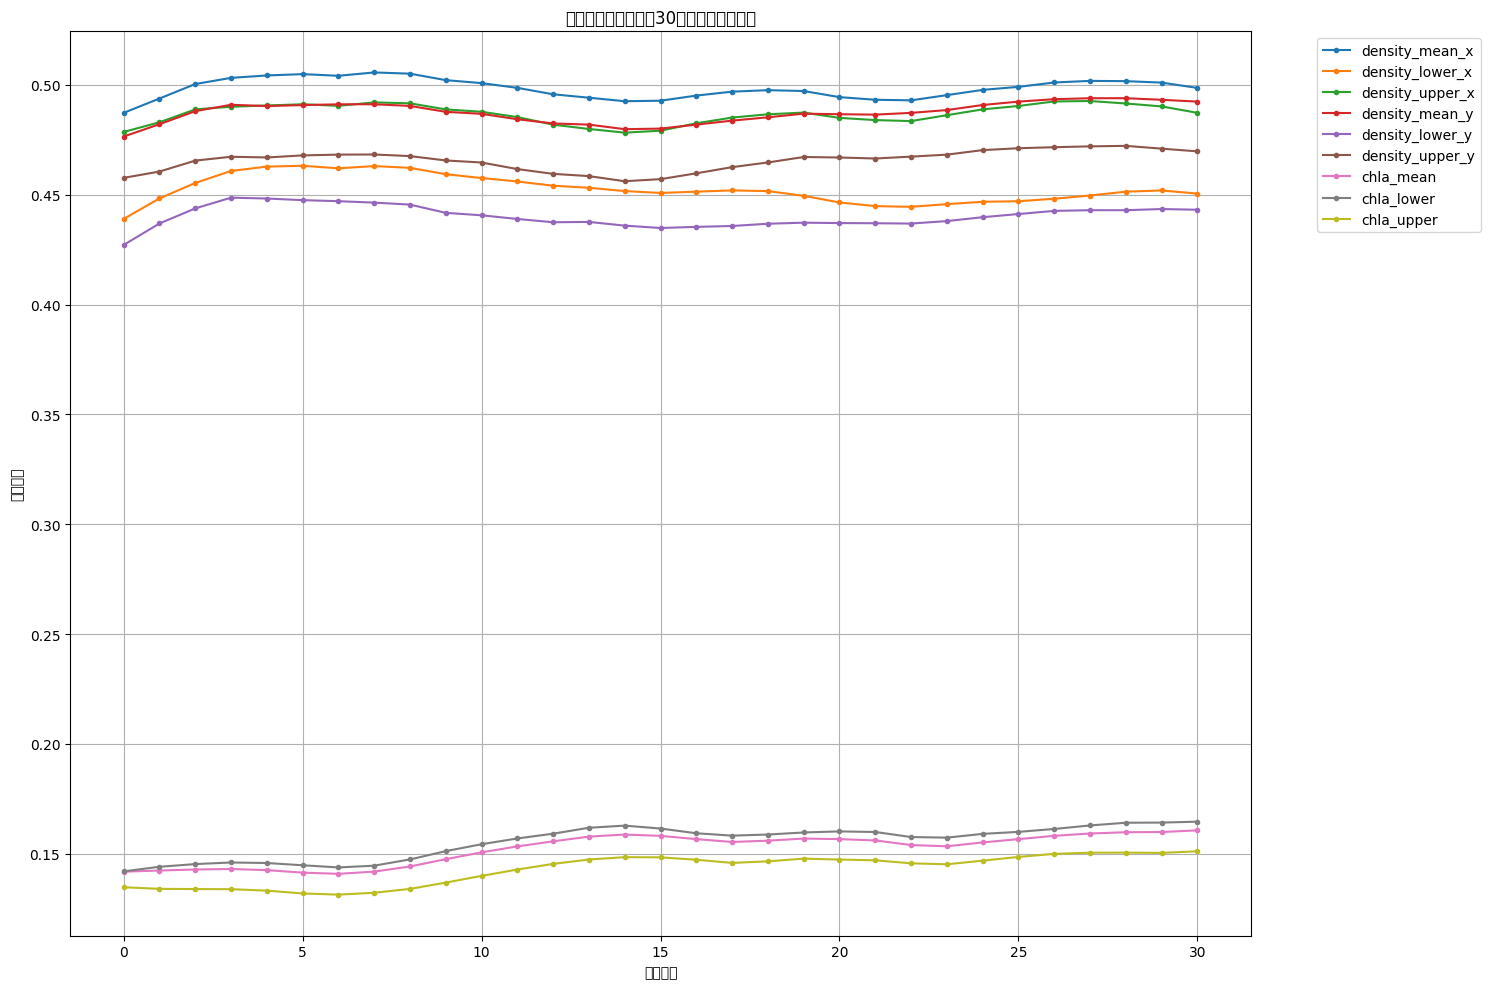


最佳滞后期分析:
--------------------------------------------------
density_mean_x:
最佳滞后期: 7天
最大相关系数: 0.506
------------------------------
density_lower_x:
最佳滞后期: 5天
最大相关系数: 0.463
------------------------------
density_upper_x:
最佳滞后期: 27天
最大相关系数: 0.493
------------------------------
density_mean_y:
最佳滞后期: 28天
最大相关系数: 0.494
------------------------------
density_lower_y:
最佳滞后期: 3天
最大相关系数: 0.449
------------------------------
density_upper_y:
最佳滞后期: 28天
最大相关系数: 0.472
------------------------------
chla_mean:
最佳滞后期: 30天
最大相关系数: 0.161
------------------------------
chla_lower:
最佳滞后期: 30天
最大相关系数: 0.165
------------------------------
chla_upper:
最佳滞后期: 30天
最大相关系数: 0.151
------------------------------

季节性滞后效应分析:
--------------------------------------------------

春季节:
density_mean_x - 最佳滞后期: 1天, 相关系数: -0.034
density_lower_x - 最佳滞后期: 1天, 相关系数: -0.056
density_upper_x - 最佳滞后期: 1天, 相关系数: -0.014
density_mean_y - 最佳滞后期: 1天, 相关系数: -0.060
density_lower_y - 最佳滞后期: 1天, 相关系数: -0.087
density_upper_y - 最佳滞后期: 1

/tmp/ipykernel_554/754546507.py:85: UserWarning: Glyph 28382 (\N{CJK UNIFIED IDEOGRAPH-6EDE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/754546507.py:85: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/754546507.py:85: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/754546507.py:85: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/754546507.py:85: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/754546507.py:85: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/754546507.py:85: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from current font.
  plt.tight_layout()
/tmp/i

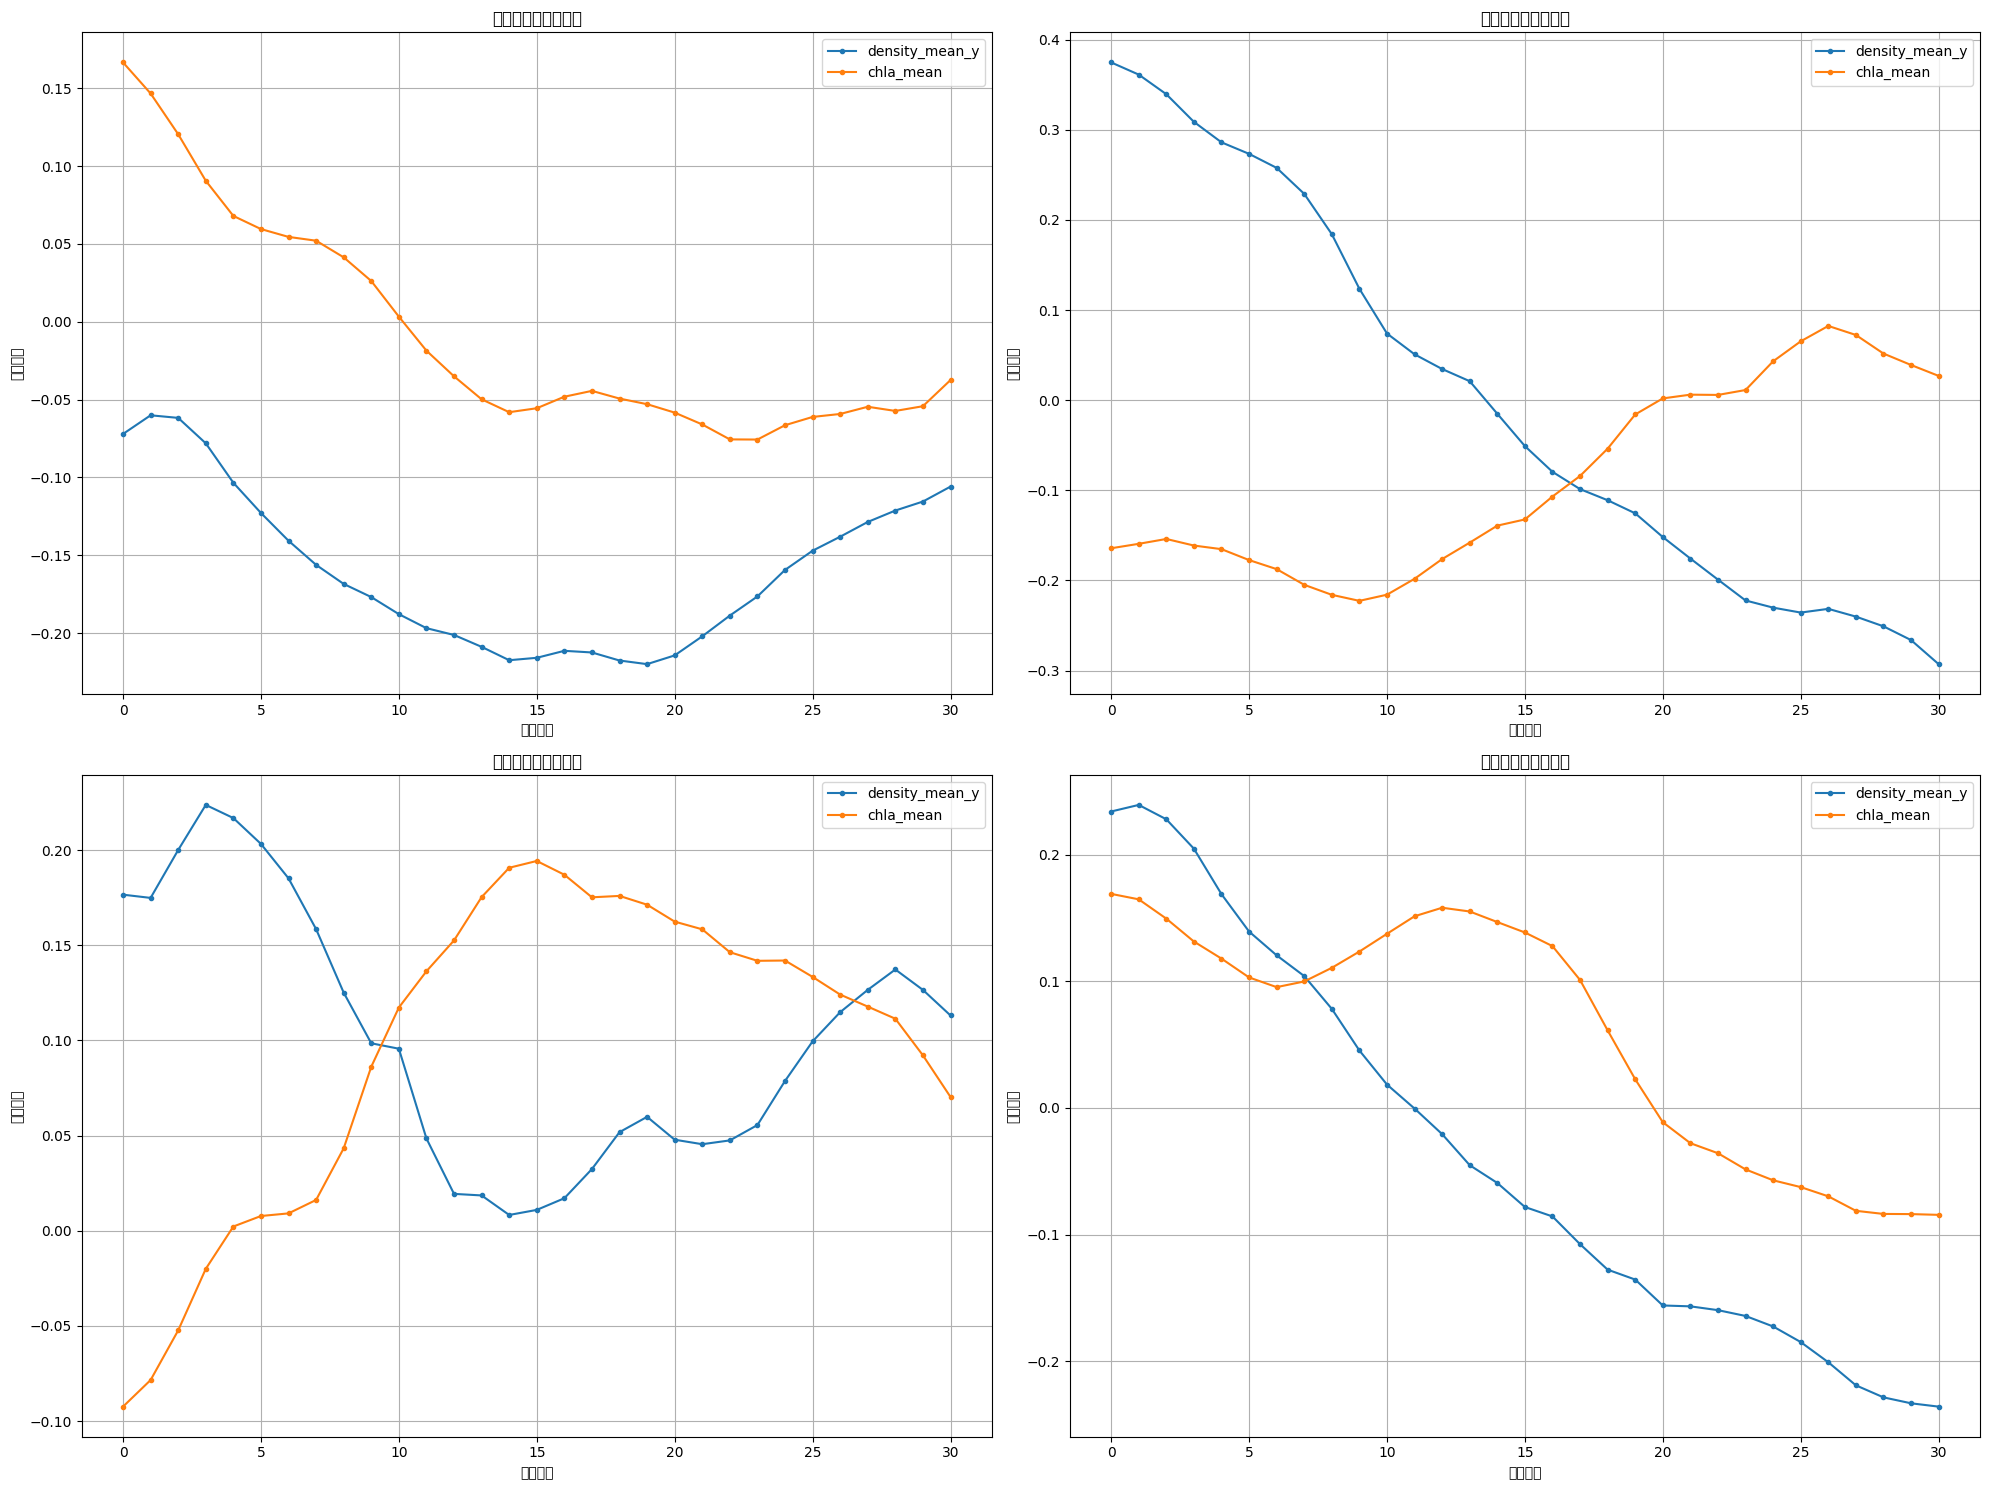

In [12]:
# 定义要分析的生物量指标
biomass_cols = ['density_mean_x', 'density_lower_x', 'density_upper_x',
                'density_mean_y', 'density_lower_y', 'density_upper_y',
                'chla_mean', 'chla_lower', 'chla_upper']

# 设置最大滞后天数为30天
max_lag = 30

# 创建一个字典来存储每个生物量指标的滞后相关性结果
lag_correlations = {}

print("温度对生物量指标的滞后影响分析(1-30天):")
print("-" * 50)

# 计算每个生物量指标在不同滞后期的相关系数
for col in biomass_cols:
    lag_correlations[col] = []
    for lag in range(max_lag + 1):
        # 计算滞后相关性
        correlation = df['temperature'].corr(df[col].shift(-lag))
        lag_correlations[col].append(correlation)
        
        # 打印重要的滞后相关性结果
        if lag in [1, 3, 7, 14, 21, 30]:
            print(f"{col} 滞后{lag}天的相关系数: {correlation:.3f}")
    print("-" * 30)

# 可视化滞后相关性
plt.figure(figsize=(15, 10))
for col in biomass_cols:
    plt.plot(range(max_lag + 1), lag_correlations[col], label=col, marker='o', markersize=3)
plt.title('温度与生物量指标的30天滞后相关性分析')
plt.xlabel('滞后天数')
plt.ylabel('相关系数')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 找出每个指标的最佳滞后期
print("\n最佳滞后期分析:")
print("-" * 50)
for col in biomass_cols:
    best_lag = lag_correlations[col].index(max(lag_correlations[col]))
    max_correlation = max(lag_correlations[col])
    print(f"{col}:")
    print(f"最佳滞后期: {best_lag}天")
    print(f"最大相关系数: {max_correlation:.3f}")
    print("-" * 30)

# 分析不同季节的滞后效应
df['season'] = pd.cut(df['date'].dt.month, bins=[0,3,6,9,12], labels=['春','夏','秋','冬'])

print("\n季节性滞后效应分析:")
print("-" * 50)
for season in ['春','夏','秋','冬']:
    season_data = df[df['season'] == season]
    print(f"\n{season}季节:")
    for col in biomass_cols:
        # 计算该季节的最大滞后相关性
        season_lag_corrs = []
        for lag in range(max_lag + 1):
            correlation = season_data['temperature'].corr(season_data[col].shift(-lag))
            season_lag_corrs.append(correlation)
        best_lag = season_lag_corrs.index(max(season_lag_corrs))
        max_correlation = max(season_lag_corrs)
        print(f"{col} - 最佳滞后期: {best_lag}天, 相关系数: {max_correlation:.3f}")

# 可视化不同季节的滞后效应
plt.figure(figsize=(20, 15))
for i, season in enumerate(['春','夏','秋','冬']):
    plt.subplot(2, 2, i+1)
    season_data = df[df['season'] == season]
    for col in ['density_mean_y', 'chla_mean']:  # 只展示主要指标
        lag_corrs = []
        for lag in range(max_lag + 1):
            correlation = season_data['temperature'].corr(season_data[col].shift(-lag))
            lag_corrs.append(correlation)
        plt.plot(range(max_lag + 1), lag_corrs, label=col, marker='o', markersize=3)
    plt.title(f'{season}季节的滞后相关性')
    plt.xlabel('滞后天数')
    plt.ylabel('相关系数')
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()


上述csv包含的column如下：
date,temperature,pH,oxygen,permanganate,NH,TP,TN,conductivity,turbidity,area,weather,max_temperature,min_temperature,aqi,aqiLevel,wind_direction,wind_power,aqiInfo,ndci,ndvi,evi,ndwi,fai,nrfi,b1,b2,b3,b4,b5,b6,b7,density_mean_x,density_lower_x,density_upper_x,FAI,density_mean_y,density_lower_y,density_upper_y,chla_mean,chla_lower,chla_upper
请你帮我写一段代码，分析wind_power这个column哪几种字段？

风力字段的所有取值:
------------------------------
0级: 20条记录
1级: 393条记录
2级: 544条记录
3级: 243条记录
4级: 31条记录
5级: 2条记录
微风: 14条记录

基本统计信息:
------------------------------
总记录数: 1247
非空记录数: 1247
空值数量: 0
不同取值数量: 7

各风力等级占比:
------------------------------
2级: 43.62%
1级: 31.52%
3级: 19.49%
4级: 2.49%
0级: 1.60%
微风: 1.12%
5级: 0.16%


/tmp/ipykernel_554/2326712619.py:31: UserWarning: Glyph 32423 (\N{CJK UNIFIED IDEOGRAPH-7EA7}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/2326712619.py:31: UserWarning: Glyph 24494 (\N{CJK UNIFIED IDEOGRAPH-5FAE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/2326712619.py:31: UserWarning: Glyph 39118 (\N{CJK UNIFIED IDEOGRAPH-98CE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/2326712619.py:31: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/2326712619.py:31: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/2326712619.py:31: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/2326712619.py:31: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  plt.tight_layout()

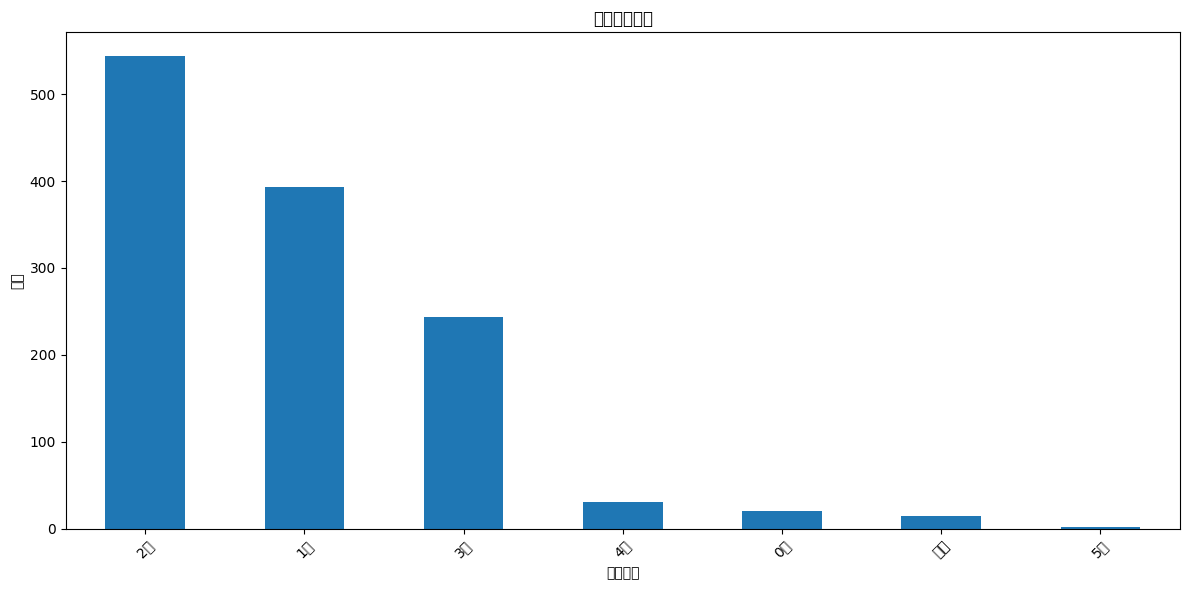

In [13]:
# 分析wind_power列的唯一值
unique_wind_powers = df['wind_power'].unique()
print("风力字段的所有取值:")
print("-" * 30)
for value in sorted(unique_wind_powers):
    count = df[df['wind_power'] == value].shape[0]
    print(f"{value}: {count}条记录")

# 统计分析
print("\n基本统计信息:")
print("-" * 30)
print(f"总记录数: {len(df['wind_power'])}")
print(f"非空记录数: {df['wind_power'].count()}")
print(f"空值数量: {df['wind_power'].isnull().sum()}")
print(f"不同取值数量: {len(unique_wind_powers)}")

# 计算各风力等级的占比
print("\n各风力等级占比:")
print("-" * 30)
wind_power_dist = df['wind_power'].value_counts(normalize=True) * 100
for wind_power, percentage in wind_power_dist.items():
    print(f"{wind_power}: {percentage:.2f}%")

# 可视化风力分布
plt.figure(figsize=(12, 6))
df['wind_power'].value_counts().plot(kind='bar')
plt.title('风力等级分布')
plt.xlabel('风力等级')
plt.ylabel('频次')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


上述csv包含的column如下：
date,temperature,pH,oxygen,permanganate,NH,TP,TN,conductivity,turbidity,area,weather,max_temperature,min_temperature,aqi,aqiLevel,wind_direction,wind_power,aqiInfo,ndci,ndvi,evi,ndwi,fai,nrfi,b1,b2,b3,b4,b5,b6,b7,density_mean_x,density_lower_x,density_upper_x,FAI,density_mean_y,density_lower_y,density_upper_y,chla_mean,chla_lower,chla_upper
请你帮我写一段代码，全方位地分析wind_power和生物量指标，包括密度均值及置信区间(density_mean_x/y, density_lower_x/y, density_upper_x/y)和叶绿素a浓度及置信区间(chla_mean, chla_lower, chla_upper)之间的相关性。我想要知道风力对生物量指标的影响是线性相关的？还是存在一个阈值，比如大于“4级”的情况，更容易导致生物量指标的变化。

各风力阈值的相关性分析(包含滞后效应):
--------------------------------------------------

风力2级作为阈值时:

滞后1天的相关性:
density_mean_y: -0.088
density_lower_y: -0.127
density_upper_y: -0.061

叶绿素a相关性:
chla_mean: -0.037
chla_lower: -0.036
chla_upper: -0.037

滞后2天的相关性:
density_mean_y: -0.113
density_lower_y: -0.148
density_upper_y: -0.087

叶绿素a相关性:
chla_mean: -0.024
chla_lower: -0.031
chla_upper: -0.020

滞后3天的相关性:
density_mean_y: -0.128
density_lower_y: -0.186
density_upper_y: -0.089

叶绿素a相关性:
chla_mean: -0.029
chla_lower: -0.030
chla_upper: -0.029

滞后4天的相关性:
density_mean_y: -0.132
density_lower_y: -0.207
density_upper_y: -0.083

叶绿素a相关性:
chla_mean: -0.045
chla_lower: -0.046
chla_upper: -0.044

滞后5天的相关性:
density_mean_y: -0.149
density_lower_y: -0.206
density_upper_y: -0.109

叶绿素a相关性:
chla_mean: -0.074
chla_lower: -0.078
chla_upper: -0.071

滞后6天的相关性:
density_mean_y: -0.133
density_lower_y: -0.198
density_upper_y: -0.089

叶绿素a相关性:
chla_mean: -0.104
chla_lower: -0.106
chla_upper: -0.103

滞后7天的相关性:
density_mean_y: -

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 32423 (\N{CJK UNIFIED IDEOGRAPH-7EA7}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 39118 (\N{CJK UNIFIED IDEOGRAPH-98CE}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 38408 (\N{CJK UNIFIED IDEOGRAPH-9608}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.draw()
/root/.conda/envs/hydro/envs/aie-sdk/lib

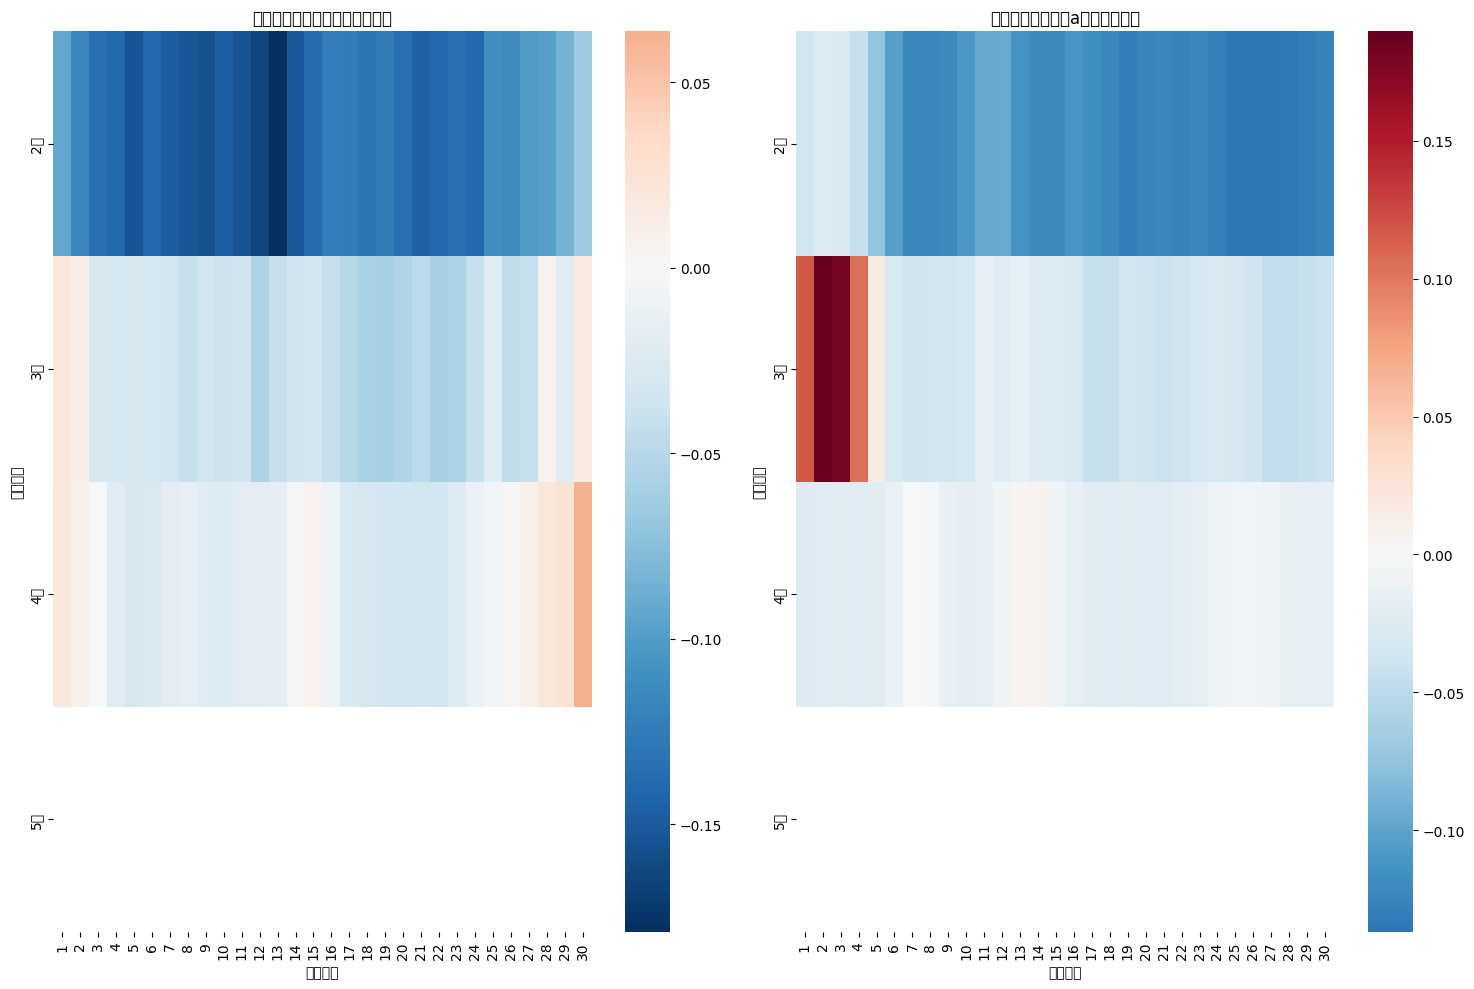

/tmp/ipykernel_554/2835923681.py:108: UserWarning: Glyph 32423 (\N{CJK UNIFIED IDEOGRAPH-7EA7}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/2835923681.py:108: UserWarning: Glyph 24494 (\N{CJK UNIFIED IDEOGRAPH-5FAE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/2835923681.py:108: UserWarning: Glyph 39118 (\N{CJK UNIFIED IDEOGRAPH-98CE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/2835923681.py:108: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/2835923681.py:108: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/2835923681.py:108: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_554/2835923681.py:108: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_l

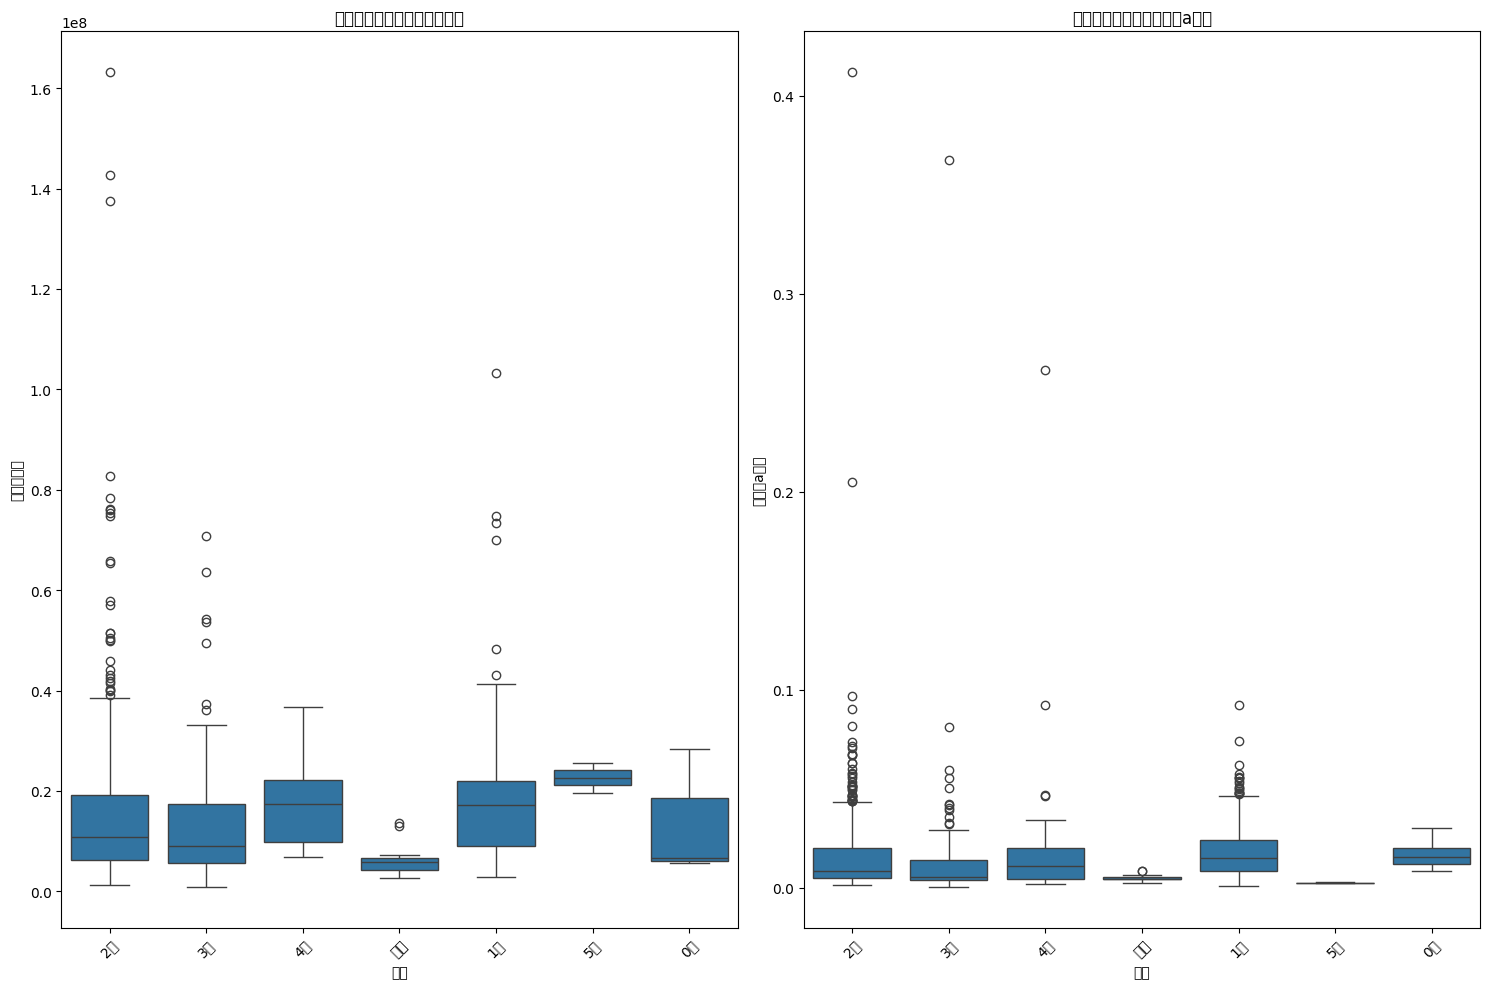


各风力等级的统计分析:
--------------------------------------------------

藻密度统计分析:

density_mean_y:

风力2级阈值:
阈值以下均值: 15900067.34
阈值以上均值: 13314940.30
t统计量: 2.917
p值: 0.004

风力3级阈值:
阈值以下均值: 15250570.07
阈值以上均值: 18172631.69
t统计量: -1.271
p值: 0.204

风力4级阈值:
阈值以下均值: 15316215.99
阈值以上均值: 22600000.00
t统计量: -0.790
p值: 0.430

风力5级阈值:
阈值以下均值: 15327898.08
阈值以上均值: nan
t统计量: nan
p值: nan

density_lower_y:

风力2级阈值:
阈值以下均值: 12888483.47
阈值以上均值: 10137934.98
t统计量: 4.263
p值: 0.000

风力3级阈值:
阈值以下均值: 12238664.36
阈值以上均值: 13789362.78
t统计量: -0.923
p值: 0.356

风力4级阈值:
阈值以下均值: 12265505.60
阈值以上均值: 21116513.22
t统计量: -1.314
p值: 0.189

风力5级阈值:
阈值以下均值: 12279701.29
阈值以上均值: nan
t统计量: nan
p值: nan

density_upper_y:

风力2级阈值:
阈值以下均值: 18938436.89
阈值以上均值: 16461910.70
t统计量: 1.993
p值: 0.046

风力3级阈值:
阈值以下均值: 18277071.55
阈值以上均值: 22555900.59
t统计量: -1.330
p值: 0.184

风力4级阈值:
阈值以下均值: 18381158.72
阈值以上均值: 24083486.78
t统计量: -0.442
p值: 0.659

风力5级阈值:
阈值以下均值: 18390304.39
阈值以上均值: nan
t统计量: nan
p值: nan

叶绿素a统计分析:

chla_mean:

风力2级阈值:
阈值以下均值: 0.02
阈值以上均值

/tmp/ipykernel_554/2835923681.py:123: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_ind(below_threshold.dropna(), above_threshold.dropna())
/tmp/ipykernel_554/2835923681.py:139: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_ind(below_threshold.dropna(), above_threshold.dropna())


In [14]:
# 定义生物量指标列
density_cols = ['density_mean_y', 'density_lower_y', 'density_upper_y']
chla_cols = ['chla_mean', 'chla_lower', 'chla_upper']

# 将风力转换为数值型,处理"微风"的情况
df['wind_power_num'] = df['wind_power'].map(lambda x: 1 if x == '微风' else float(x.replace('级','')))

# 将日期列转换为datetime类型
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# 遍历不同的风力阈值,分析相关性
max_wind_level = int(df['wind_power_num'].max())

# 创建存储相关系数的字典
correlations = {
    'density': {threshold: [] for threshold in range(2, max_wind_level + 1)},
    'chla': {threshold: [] for threshold in range(2, max_wind_level + 1)}
}

print("各风力阈值的相关性分析(包含滞后效应):")
print("-" * 50)

for threshold in range(2, max_wind_level + 1):
    # 创建阈值的one-hot编码
    col_name = f'wind_power_above_{threshold}'
    df[col_name] = (df['wind_power_num'] > threshold).astype(int)
    
    print(f"\n风力{threshold}级作为阈值时:")
    
    # 分析滞后1-30天的相关性
    for lag in range(1, 31):
        print(f"\n滞后{lag}天的相关性:")
        
        # 计算滞后特征
        lagged_wind = df[col_name].shift(lag)
        
        # 计算与藻密度指标的平均相关性
        density_corrs = []
        for density_col in density_cols:
            corr = lagged_wind.corr(df[density_col])
            density_corrs.append(corr)
            print(f"{density_col}: {corr:.3f}")
        correlations['density'][threshold].append(np.mean(density_corrs))
            
        # 计算与叶绿素a的平均相关性
        chla_corrs = []
        print("\n叶绿素a相关性:")
        for chla_col in chla_cols:
            corr = lagged_wind.corr(df[chla_col])
            chla_corrs.append(corr)
            print(f"{chla_col}: {corr:.3f}")
        correlations['chla'][threshold].append(np.mean(chla_corrs))

# 绘制滞后相关性热力图
plt.figure(figsize=(15, 10))

# 准备热力图数据
lag_days = list(range(1, 31))
thresholds = list(range(2, max_wind_level + 1))

# 藻密度相关性热力图
plt.subplot(1, 2, 1)
density_heatmap_data = np.array([correlations['density'][t] for t in thresholds])
sns.heatmap(density_heatmap_data, 
            xticklabels=lag_days,
            yticklabels=[f"{t}级" for t in thresholds],
            cmap='RdBu_r',
            center=0)
plt.title('风力阈值与藻密度的滞后相关性')
plt.xlabel('滞后天数')
plt.ylabel('风力阈值')

# 叶绿素a相关性热力图
plt.subplot(1, 2, 2)
chla_heatmap_data = np.array([correlations['chla'][t] for t in thresholds])
sns.heatmap(chla_heatmap_data,
            xticklabels=lag_days,
            yticklabels=[f"{t}级" for t in thresholds],
            cmap='RdBu_r',
            center=0)
plt.title('风力阈值与叶绿素a的滞后相关性')
plt.xlabel('滞后天数')
plt.ylabel('风力阈值')

plt.tight_layout()
plt.show()

# 可视化不同阈值的效果
plt.figure(figsize=(15, 10))

# 绘制藻密度的箱线图
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='wind_power', y='density_mean_y')
plt.title('不同风力等级下的藻密度分布')
plt.xlabel('风力')
plt.ylabel('藻密度均值')
plt.xticks(rotation=45)

# 绘制叶绿素a的箱线图
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='wind_power', y='chla_mean')
plt.title('不同风力等级下的叶绿素a分布')
plt.xlabel('风力')
plt.ylabel('叶绿素a均值')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 统计分析各风力等级的效应
print("\n各风力等级的统计分析:")
print("-" * 50)

# 藻密度的统计分析
print("\n藻密度统计分析:")
for density_col in density_cols:
    print(f"\n{density_col}:")
    for threshold in range(2, max_wind_level + 1):
        below_threshold = df[df['wind_power_num'] <= threshold][density_col]
        above_threshold = df[df['wind_power_num'] > threshold][density_col]
        
        t_stat, p_value = stats.ttest_ind(below_threshold.dropna(), above_threshold.dropna())
        
        print(f"\n风力{threshold}级阈值:")
        print(f"阈值以下均值: {below_threshold.mean():.2f}")
        print(f"阈值以上均值: {above_threshold.mean():.2f}")
        print(f"t统计量: {t_stat:.3f}")
        print(f"p值: {p_value:.3f}")

# 叶绿素a的统计分析        
print("\n叶绿素a统计分析:")
for chla_col in chla_cols:
    print(f"\n{chla_col}:")
    for threshold in range(2, max_wind_level + 1):
        below_threshold = df[df['wind_power_num'] <= threshold][chla_col]
        above_threshold = df[df['wind_power_num'] > threshold][chla_col]
        
        t_stat, p_value = stats.ttest_ind(below_threshold.dropna(), above_threshold.dropna())
        
        print(f"\n风力{threshold}级阈值:")
        print(f"阈值以下均值: {below_threshold.mean():.2f}")
        print(f"阈值以上均值: {above_threshold.mean():.2f}")
        print(f"t统计量: {t_stat:.3f}")
        print(f"p值: {p_value:.3f}")


In [27]:
import matplotlib.font_manager as fm

# 获取系统中所有可用的字体列表
available_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# 打印所有字体及其路径
for font in available_fonts:
    print(font)

/usr/share/fonts/google-droid-sans-fonts/DroidSansHebrew-Regular.ttf
/usr/share/fonts/dejavu-sans-fonts/DejaVuSansCondensed.ttf
/usr/share/fonts/cantarell/Cantarell-Light.otf
/usr/share/fonts/urw-base35/URWGothic-Book.otf
/usr/share/fonts/adobe-source-code-pro/SourceCodePro-Black.otf
/usr/share/fonts/google-noto-cjk/NotoSansCJK-DemiLight.ttc
/usr/share/fonts/urw-base35/P052-Roman.otf
/usr/share/fonts/google-droid-sans-fonts/DroidSansTamil-Regular.ttf
/usr/share/fonts/urw-base35/NimbusSansNarrow-Oblique.otf
/usr/share/fonts/urw-base35/Z003-MediumItalic.otf
/usr/share/fonts/google-droid-sans-fonts/DroidKufi-Bold.ttf
/usr/share/fonts/urw-base35/NimbusRoman-Bold.otf
/usr/share/fonts/adobe-source-code-pro/SourceCodePro-MediumIt.otf
/usr/share/fonts/urw-base35/NimbusSans-Regular.otf
/usr/share/fonts/google-droid-sans-fonts/DroidSansThai.ttf
/usr/share/fonts/adobe-source-code-pro/SourceCodePro-Bold.otf
/usr/share/fonts/urw-base35/NimbusMonoPS-Bold.otf
/usr/share/fonts/cantarell/Cantarell-Bold

findfont: Generic family 'sans-serif' not found because none of the following families were found: NotoSansCJK-Regular
findfont: Generic family 'sans-serif' not found because none of the following families were found: NotoSansCJK-Regular
findfont: Generic family 'sans-serif' not found because none of the following families were found: NotoSansCJK-Regular
findfont: Generic family 'sans-serif' not found because none of the following families were found: NotoSansCJK-Regular
findfont: Generic family 'sans-serif' not found because none of the following families were found: NotoSansCJK-Regular
findfont: Generic family 'sans-serif' not found because none of the following families were found: NotoSansCJK-Regular
findfont: Generic family 'sans-serif' not found because none of the following families were found: NotoSansCJK-Regular
findfont: Generic family 'sans-serif' not found because none of the following families were found: NotoSansCJK-Regular
findfont: Generic family 'sans-serif' not found 

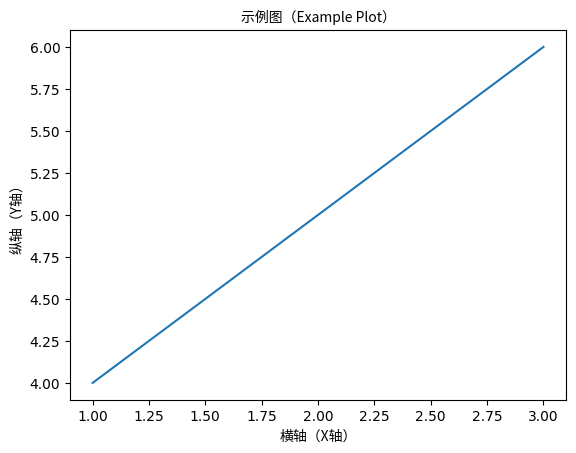

In [30]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置中文字体
font = FontProperties(fname='/usr/share/fonts/google-noto-cjk/NotoSansCJK-Regular.ttc')
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

# 绘制图形
plt.plot([1, 2, 3], [4, 5, 6])
plt.xlabel('横轴（X轴）', fontproperties=font)
plt.ylabel('纵轴（Y轴）', fontproperties=font)
plt.title('示例图（Example Plot）', fontproperties=font)
plt.show()